# **Projekt: Fehlererkennung in Getrieben**
## Netztyp 2: FFT-Net

#### **Vorbereitung**

In [1]:
# import libraries
import numpy as np
import os
from pandas import DataFrame, concat
from pathlib import Path

# module imports from /src
if Path.cwd().stem == "notebooks":
    os.chdir( Path.cwd().parent)

import src.data_loader as dl
import src.visualization as vis
import src.model_constructor as mc

In [2]:
# set the source directory for the preprocessed data to use
SOURCE: str = "1369c9db-a3bc-4a53-932f-e54121ff6b6f"

# setup a single index for control purposes
CONTROL_INDEX: int = 1

In [3]:
# setup system and check the number of cpu cores and gpus available
mc.system_setup()

Number of CPU cores:		12
Number of GPUs available:	0


#### **Laden der Datensätze**

In [4]:
# load data from folder and split in training and evaluation data
data_path = Path().cwd() / "data" / "processed" / SOURCE
development_data, evaluation_data = dl.load_all_datasets(data_path)

READING DEVELOPMENT DATA
0D_0_fft.csv successfully loaded.
0D_1_fft.csv successfully loaded.
1D_0_fft.csv successfully loaded.
1D_1_fft.csv successfully loaded.
2D_0_fft.csv successfully loaded.
2D_1_fft.csv successfully loaded.
3D_0_fft.csv successfully loaded.
3D_1_fft.csv successfully loaded.
4D_0_fft.csv successfully loaded.
4D_1_fft.csv successfully loaded.
READING EVALUATION DATA
0E_0_fft.csv successfully loaded.
0E_1_fft.csv successfully loaded.
1E_0_fft.csv successfully loaded.
1E_1_fft.csv successfully loaded.
2E_0_fft.csv successfully loaded.
2E_1_fft.csv successfully loaded.
3E_0_fft.csv successfully loaded.
3E_1_fft.csv successfully loaded.
4E_0_fft.csv successfully loaded.
4E_1_fft.csv successfully loaded.
READING COMPLETED


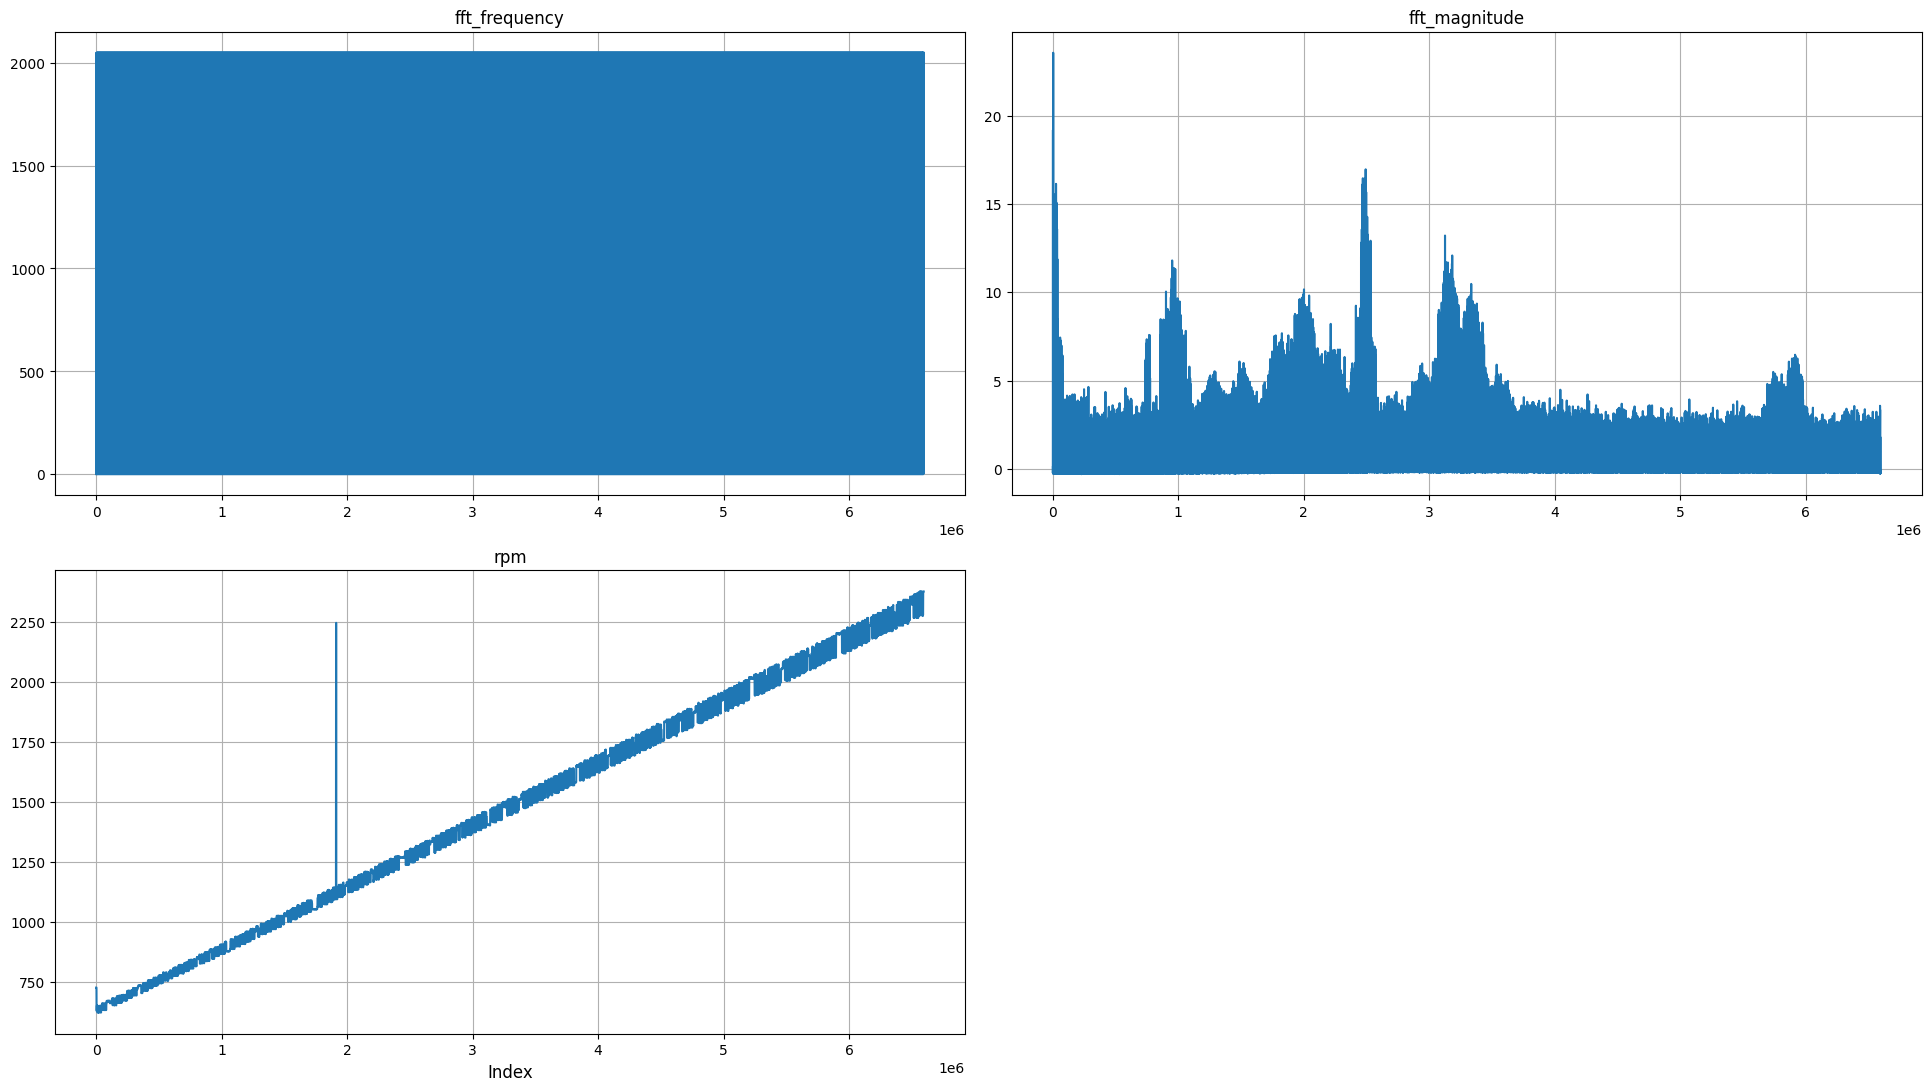

In [5]:
# visualize one random dataset for data validation
vis.plot_columns_as_subplots(development_data[CONTROL_INDEX],
                             development_data[CONTROL_INDEX].columns)

#### **Das Neuronale Netz**



In [6]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras.utils import to_categorical
from pandas import concat

def shuffle_data_and_labels(data, labels):
    # Überprüfen, ob die Anzahl der Datenpunkte und Labels gleich ist
    assert data.shape[0] == labels.shape[0], "Anzahl der Datenpunkte muss der Anzahl der Labels entsprechen."
    
    # Erzeuge einen zufälligen Index
    indices = np.arange(data.shape[0])
    np.random.shuffle(indices)
    
    # Wende den zufälligen Index auf beide Arrays an
    shuffled_data = data[indices]
    shuffled_labels = labels[indices]
    
    return shuffled_data, shuffled_labels


index = 1
def prepare_data_for_input(datasets: list[DataFrame]):
    keys = []
    for index, dataset in enumerate(datasets):
        keys.append(dataset.attrs["path"].stem)

        # if dataset.attrs["unbalance"] == "none":
        #     dataset["label"] = "none"
        # else:
        #     dataset["label"] = "some"

        dataset["label"] = dataset.attrs["unbalance"]
        datasets[index] = dataset

    return concat(datasets, keys=keys)


ds = prepare_data_for_input(development_data)

display(ds)

training_samples = ds["fft_magnitude"].to_numpy()
training_labels = ds["label"].to_numpy()



training_samples = np.reshape(training_samples, (-1, 2048))
training_labels = np.reshape(training_labels, (-1, 2048))
training_labels = training_labels[:,0]

# encode labels

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(training_labels)
y_one_hot = to_categorical(y_encoded, num_classes=5)


training_samples, y_one_hot = shuffle_data_and_labels(training_samples, y_one_hot)

print(training_samples.shape)
print(y_one_hot.shape)

fft_frequency  fft_magnitude          rpm   label
0D_0_fft 0                  1.0      66.468332   640.782603    none
         1                  2.0      32.948368   640.782603    none
         2                  3.0      21.774169   640.782603    none
         3                  4.0      16.236190   640.782603    none
         4                  5.0      13.088005   640.782603    none
...                         ...            ...          ...     ...
4D_1_fft 6592507         2044.0      -0.040120  2371.839888  strong
         6592508         2045.0      -0.061268  2371.839888  strong
         6592509         2046.0      -0.081246  2371.839888  strong
         6592510         2047.0       0.007892  2371.839888  strong
         6592511         2048.0      -0.133122  2371.839888  strong

[65839104 rows x 4 columns]

(32148, 2048)
(32148, 5)


In [7]:
# Klassen
print("Eindeutige Klassen im Datensatz:", np.unique(training_labels))

# Klassenverteilung
class_counts = np.sum(y_one_hot, axis=0)  # Summiere jede Spalte im One-Hot-Encoding
print("Klassenverteilung:", class_counts)

Eindeutige Klassen im Datensatz: ['moderat' 'none' 'significant' 'slight' 'strong']
Klassenverteilung: [6430. 6430. 6429. 6430. 6429.]


In [8]:
LEARNING_RATE: float = 0.0001
MOMENTUM: float = 0.8 #0.9
BATCH_SIZE: int = 64
EPOCHS: int = 10
THRESHOLD = 0.95
NUMBER_OF_HIDDEN_LAYERS: int = 2

In [9]:
import keras
from keras import layers, regularizers
input_shape = training_samples.shape
output_shape = y_one_hot.shape
print(output_shape)


model = keras.Sequential()
model.add(layers.Dense(2048, input_shape=(input_shape[1],)))

# add the number of hidden layers
for _ in range(NUMBER_OF_HIDDEN_LAYERS):
    model.add(layers.Dense(units = 1024,
                           kernel_regularizer=regularizers.L2(0.001)))
    model.add(layers.LeakyReLU(negative_slope=0.3))
    model.add(layers.Dropout(0.2))
    

model.add(layers.Dense(output_shape[1], activation="sigmoid"))
model

model.summary()

(32148, 5)


c:\Users\Studium\Documents\GitHub\ai-gear-fault-detection\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 2048)           │     4,196,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         5,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,349,253 (28.04 MB)

 Trainable params: 7,349,253 (28.04 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

'''
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[
        keras.metrics.BinaryAccuracy(),
        keras.metrics.FalseNegatives(),
    ],
)

model.fit(x=training_samples,y=y_one_hot, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.1)

'''


model.compile(
    # optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE, name="adam"),
    optimizer=keras.optimizers.SGD(learning_rate=LEARNING_RATE, momentum=MOMENTUM),
    loss = keras.losses.CategoricalCrossentropy(), # für Multiklassen
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        keras.metrics.Precision(name="precision", thresholds=THRESHOLD),
        keras.metrics.Recall(name="recall", thresholds=THRESHOLD),
    ],
)

model.fit(
    x=training_samples,
    y=y_one_hot,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    #class_weight=class_weights,
)


Epoch 1/10
453/453 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - accuracy: 0.3487 - loss: 3.8888 - precision: 0.0675 - recall: 8.5313e-06 - val_accuracy: 0.6843 - val_loss: 3.5445 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
453/453 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.6341 - loss: 3.5127 - precision: 0.4982 - recall: 6.4687e-04 - val_accuracy: 0.7994 - val_loss: 3.2699 - val_precision: 0.8571 - val_recall: 0.0019
Epoch 3/10
227/453 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.7408 - loss: 3.2878 - precision: 0.9631 - recall: 0.0126

In [ ]:
test_dataset = prepare_data_for_input(evaluation_data)

test_samples = test_dataset["fft_magnitude"].to_numpy()
test_labels = test_dataset["label"].to_numpy()

test_samples = np.reshape(test_samples, (-1, 2048))
test_labels = np.reshape(test_labels, (-1, 2048))
test_labels = test_labels[:,0]

# encode labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(test_labels)
y_one_hot = to_categorical(y_encoded, num_classes=5)


test_samples, test_labels = shuffle_data_and_labels(test_samples, y_one_hot)

print(test_samples.shape)
print(test_labels.shape)

(8347, 2048)
(8347, 5)


In [ ]:
evaluation = model.evaluate(test_samples, test_labels, verbose=1, return_dict=True)

display(evaluation)

predictions = model.predict(test_samples)

display(predictions)

261/261 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5230 - loss: 4.5039 - precision: 0.4097 - recall: 0.5168


{'accuracy': 0.5205463171005249,
 'loss': 4.514516830444336,
 'precision': 0.40797632932662964,
 'recall': 0.5122798681259155}

261/261 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


array([[9.3477094e-01, 9.9260575e-01, 9.9227297e-01, 1.5482592e-02,
        8.6802349e-04],
       [1.0579685e-04, 6.8770856e-02, 9.0888792e-01, 9.4113076e-01,
        9.9987859e-01],
       [4.7908248e-03, 9.6102029e-01, 8.7935859e-01, 4.1691604e-01,
        9.5544350e-01],
       ...,
       [8.2339116e-05, 6.9799043e-02, 9.4105357e-01, 7.2779965e-01,
        9.9991292e-01],
       [2.4880592e-05, 4.3068117e-01, 9.8458719e-01, 6.6103613e-01,
        9.9979609e-01],
       [3.0098322e-01, 9.9997652e-01, 9.9638259e-01, 1.4978446e-03,
        1.1573649e-03]], dtype=float32)

In [ ]:
# WIP: Qualität des Netzes visualisieren
y_true = training_labels  # Direkt die numerischen Labels verwenden
y_pred = np.argmax(model.predict(training_samples), axis=1)  # Vorhergesagte Klassen

vis.plot_confusion_matrix(
    y_true=y_true,
    y_pred=y_pred,
    class_names=["none", "slight", "moderat", "significant", "strong"]
)


1005/1005 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step


AttributeError: module 'src.visualization' has no attribute 'plot_confusion_matrix'

In [ ]:
predictions = model.predict(training_samples)
predicted_classes = np.argmax(predictions, axis=1)
predicted_label = encoder.inverse_transform(predicted_classes)
print(predicted_label)